In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from keras import utils
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as mpatches

In [ ]:
# dir_path points towards where to find the image dataset
dir_path = "brain_tumor_dataset"
IMAGE_SHAPE = (224, 224)
MUBA_ITERS = 50

random_sample = 1

# Read the folders folders
directories = os.listdir(dir_path)

files = [] 
labels = []

# Read files for each directory
for folder in directories:
    
    fileList = glob.glob(f'{dir_path}/{folder}/*')
    labels.extend([folder for _ in fileList])
    files.extend(fileList)

len(files), len(labels)

In [ ]:
# At this point "no" is [1,0] and "yes" is [0,1]
yes_count = 0
for val in labels:
    if val == "yes":
        yes_count += 1
print(yes_count)

In [ ]:
# One hot encoding

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = utils.to_categorical(encoded_Y,dtype ="uint8", num_classes = 2)

labels = np.array(dummy_y)

print(f"Classes are {encoder.classes_}")

In [ ]:
# Split the data into testing, training and validation data
# As using a random sample = 100, the testing set is the same as used for the model.
# x_train, x_tv, y_train, y_tv = train_test_split(files, labels, test_size=.3, random_state = random_sample)
# x_test, x_val, y_test, y_val = train_test_split(x_tv, y_tv, test_size=.5, random_state = random_sample)

x_train, x_tv, y_train, y_tv = train_test_split(files, labels, test_size=.5, random_state = random_sample)
x_test, x_val, y_test, y_val = train_test_split(x_tv, y_tv, test_size=.4, random_state = random_sample)

# x_test, x_waste, y_test, y_waste = train_test_split(x_test, y_test, test_size=.8, random_state = random_sample)

In [ ]:
images = []
labels = []

print("Preparing testing data")
for file, label in zip(x_test, y_test):

    # Prepare the image
    new_file = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(new_file)
    # Append to array
    images.append(img_array)
    labels.append(label)

In [ ]:
# At this point "no" is [1,0] and "yes" is [0,1]
yes_count = 0
for val in labels:
    if val[1] == 1:
        yes_count += 1
print(yes_count)

In [ ]:
# At this point "no" is [1,0] and "yes" is [0,1]

In [ ]:
model = keras.models.load_model("lots_of_test_data_2.h5")

# "best_simple_model_2.h5" 92% - accidently overide it :( 

In [ ]:
basic_results = model.predict(np.stack(images))

In [ ]:
NUM = 14
plt.imshow(tf.keras.utils.array_to_img(images[NUM]))
print(labels[NUM], labels[NUM][1])
print(basic_results[NUM], np.argmax(basic_results[NUM]))
# A tumour should have a label of [0,1]
# We want a value of 1 for a tumour
# Therefore we should use teh second column, index 1

In [ ]:
argmax_preds = [np.argmax(r) for r in basic_results] # 0 if no tumour, 1 if yes tumour
labels = [label[1] for label in y_test] # 0 if no tumour, 1 if yes tumour
acc = sklearn.metrics.accuracy_score(labels,argmax_preds)

In [ ]:
initial_df = pd.DataFrame()
initial_df["class"] = labels # 0 if no tumour, 1 if there is a tumour
initial_df["image_index"] = [i for i in range(len(images))]
initial_df["confidence_class_0"] = [alpha[0] for alpha in basic_results]
initial_df["confidence_class_1"] = [alpha[1] for alpha in basic_results]

In [ ]:
class_zero_df = initial_df[initial_df["class"] == 0] # no tumour
class_one_df = initial_df[initial_df["class"] == 1]
class_one_length = len(class_one_df)
class_zero_length = len(class_zero_df)

In [ ]:
print(class_one_length,class_zero_length)

In [ ]:
muba_df = pd.DataFrame(columns = [
                    "alpha_class_0",
                    "alpha_class_1",
                    "image",
                    "y_value_class_1",
    ])

In [ ]:
# Iterate through NO tumour images
for index0, row0 in class_zero_df.iterrows():
    
    # Iterate through YES tumour images
    for index1, row1 in class_one_df.iterrows():

        for i in range(MUBA_ITERS):
            
            # Mixup images
            lam = (1/MUBA_ITERS) * np.random.rand() + ( (i) / MUBA_ITERS)
            new_img = lam * images[int(row0["image_index"])] + (1 - lam) * images[int(row1["image_index"])]

            row = pd.DataFrame([({ "alpha_class_0": lam, # row 0 is multiplied by lam
                    "alpha_class_1": 1-lam,
                    "image": new_img,
                    "y_value_class_1": (row1["confidence_class_1"] - row0["confidence_class_1"]) * (1-lam) + row0["confidence_class_1"], # Confidence in yes, there is a tumour
                    })])
            
            
            muba_df = pd.concat([muba_df, row],axis=0, ignore_index=True)


            




In [ ]:
muba_df.head(20)

In [ ]:
#muba_df.head()

In [ ]:
plt.hist(muba_df["alpha_class_1"], bins = 20)

In [ ]:
# Get Predictions
result = model.predict(np.stack(muba_df["image"]))


In [ ]:
pred_array = [np.argmax(individual_result) for individual_result in result] # 0 is no, 1 is yes

In [ ]:
analysis_df = muba_df.drop('image',axis=1)

predictions = pd.DataFrame()
predictions["pred"] = pred_array

# Merge on predictions
analysis_df = analysis_df.join(predictions)
boundary_df = pd.DataFrame(columns = ["alpha","y"])

for i in range(int(len(analysis_df)/MUBA_ITERS)):
    # Create a mask to split df in to blocks of 20
    mask = (analysis_df.index >= MUBA_ITERS*i) & (analysis_df.index < MUBA_ITERS*i + MUBA_ITERS)
    window_df = analysis_df.loc[mask]

    # Find the index in which the prediction changes
    changing_pred_index = (window_df["pred"].diff()[window_df["pred"].diff() != 0].index.values)
    for boundary in changing_pred_index[1:]: # If pred doesn't change will equal 1
        row0 = window_df[window_df.index == boundary-1]
        row1 = window_df[window_df.index == boundary]
        middle_alpha = (row1["alpha_class_1"][boundary] + row0["alpha_class_1"][boundary-1]) / 2
        middle_y = row0["y_value_class_1"][boundary-1] + ( (row1["y_value_class_1"][boundary] - row0["y_value_class_1"][boundary-1]) / 2 )
        new_row = pd.DataFrame([{
            "alpha":middle_alpha,
            "y":middle_y
        }])
        
        boundary_df = pd.concat([boundary_df, new_row], axis=0, ignore_index = True)

In [ ]:
correct_alphas = (analysis_df[analysis_df["pred"] == analysis_df["alpha_class_1"].round()])["alpha_class_1"]
incorrect_alphas = (analysis_df[analysis_df["pred"] != analysis_df["alpha_class_1"].round()])["alpha_class_1"]



In [ ]:
fig, ax = plt.subplots(3,1,gridspec_kw={'height_ratios': [3, 1,1]}, figsize = (12,10),sharex = True)
fig.subplots_adjust(hspace=0.2)

ax[0].plot([0,1],[0.5,0.5],color = "black", linestyle = "--",alpha=0.2)
ax[0].scatter(muba_df["alpha_class_1"],muba_df["y_value_class_1"], marker = ".", alpha = 0.2,color = ["red" if x == 1 else "blue" for x in predictions["pred"]], label = "Mixup Images")
ax[0].scatter(initial_df["class"],initial_df["confidence_class_1"], marker = ".", color = "black", label = "True Images")
ax[0].scatter(boundary_df["alpha"],boundary_df["y"], marker = ".", color = "green")
ax[0].set_ylim([-0.05,1.05])

# Create a legend with a color box
no_patch = mpatches.Patch(color='red', label='MUBA Image - Predicted Yes')
yes_patch = mpatches.Patch(color='blue', label='MUBA Image - Predicted No')
original_patch = mpatches.Patch(color='black', label='Original Image')
middle_patch = mpatches.Patch(color='green', label='Boundary Point')

ax[0].legend(handles=[no_patch, yes_patch, original_patch, middle_patch])
ax[0].set_ylabel("Model Confidence in Predicted 'Yes Tumour' for True Images")
ax[0].text(-0.03,0.5,"'No Tumour' Cluster", rotation = "vertical", va = "center", ha = "center")
ax[0].text(1.03,0.5,"'Yes Tumour' Cluster", rotation = "vertical", va = "center", ha = "center")
ax[0].set_title(f"Model Accuracy - {round(100*acc,2)}%")

# ax.axis("off")
ax[1].hist(boundary_df["alpha"],bins=20,color="green")
mean = np.mean(boundary_df["alpha"])
ax[1].axvline(mean, color = "black", linestyle = "--", label = f"Mean = {round(mean,2)}")
ax[1].set_ylabel("N")
ax[1].set_title("Boundary Distribution Curve")
ax[1].legend()

ax[2].hist(incorrect_alphas,bins=20)
mean = np.mean(incorrect_alphas)
ax[2].axvline(mean, color = "black", linestyle = "--", label = f"Mean = {round(mean,2)}")
ax[2].set_xlabel("Proportion 'Yes'")
ax[2].set_ylabel("N")
ax[2].set_title("Error Distribution Curve")
ax[2].legend()

In [ ]:
# Cluster size n and m, total connections is n x m


In [9]:
cluster_size = [(i+1) for i in range(100)]
cluster_size_squared = [i**2 for i in cluster_size]

muba_images_5 = [5 * i for i in cluster_size_squared]
muba_images_10 = [10 * i for i in cluster_size_squared]
muba_images_20 = [20 * i for i in cluster_size_squared]
muba_images_50 = [50 * i for i in cluster_size_squared]
muba_images_100 = [100 * i for i in cluster_size_squared]

Text(0.5, 0, 'Number of Mix-Up Images Generated')

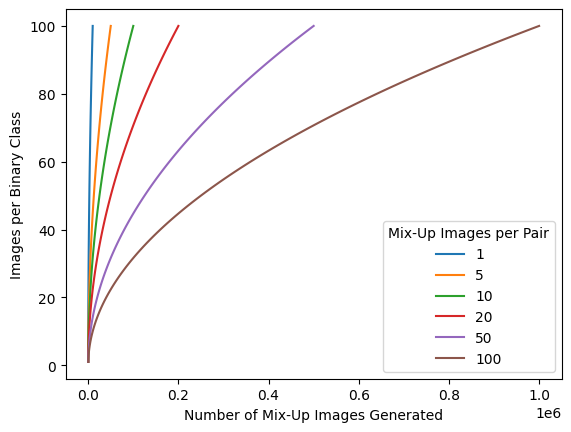

In [35]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.set_xscale('log')

plt.plot(cluster_size_squared,cluster_size,label = "1")
plt.plot(muba_images_5,cluster_size,label = "5")
plt.plot(muba_images_10,cluster_size,label = "10")
plt.plot(muba_images_20,cluster_size,label = "20")
plt.plot(muba_images_50,cluster_size,label = "50")
plt.plot(muba_images_100,cluster_size,label = "100")

plt.legend(title = "Mix-Up Images per Pair")
plt.ylabel("Images per Binary Class")
plt.xlabel("Number of Mix-Up Images Generated")